# Spotify Global Music Dataset

## 1. Installing & Importing Required Libraries

We first install and then import the libraries needed for data manipulation, visualization, and dataset downloading.

```pip install numpy```  
```pip install pandas```  
```pip install seaborn```  
```pip install matplotlib```  

```pip install kagglehub```  
```pip install kagglehub[pandas-datasets]```

In [110]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

---

## 2. Setting File Path

We specify the name of the data file in order to import it.

In [112]:
file_path = "track_data_final.csv"

---

## 3. Loading the dataset

### 3.1. Loading the Dataset with KaggleHub

We try to use KaggleHub, which directly gets the data from the online dataset _(code obtained from the Kaggle website)_.

In [113]:
# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "wardabilal/spotify-global-music-dataset-20092025",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

### 3.2. Loading the CSV Locally

>If the KaggleHub import doesn't work, we can also import the dataset from a local CSV file.

In [114]:
df = pd.read_csv(f"./data/{file_path}")

---

## 4. Cleaning the Data

We need to remove any unnecessary columns that don't provide any value to our analysis. For instance, the track number or the album it belongs won't give us any insight on how well the song performs (the album will benefit from the track, not in the other way). We'll also remove the album total tracks, the artist genre (half of the artists don't have any) and the track name and id.
<br>
We'll keep the date, as it gives us a chronological indicator.

In [115]:
# Dropping columns that do not contribute to song performance analysis
df = df.drop("track_number", axis=1)
df = df.drop("track_name", axis=1)
df = df.drop("track_id", axis=1)
df = df.drop("artist_genres", axis=1)
df = df.drop("album_id", axis=1)
df = df.drop("album_name", axis=1)
df = df.drop("album_total_tracks", axis=1)

### 4.1 Checking for Missing Values

In [116]:
# Checking for missing values
df.isnull().sum()

track_popularity      0
track_duration_ms     0
explicit              0
artist_name           4
artist_popularity     4
artist_followers      4
album_release_date    0
album_type            0
dtype: int64

### 4.2 Handling Missing Artist Information

Some rows may have missing artist names or popularity metrics. <br>
Artist names and release dates are replaced by ```"unknown"``` when missing.

In [117]:
# Identify missing artist names
missing_artist_name = [
    [index, row] for index, row in df.iterrows() 
    if pd.isna(row["artist_name"])
]
print("There are exactly " + str(len(missing_artist_name)) + " tracks with missing artists")

There are exactly 4 tracks with missing artists


In [118]:
# Filling missing numerical fields with their most common value
mode_artist_popularity = df["artist_popularity"].mode()[0]
df["artist_popularity"] = df["artist_popularity"].fillna(mode_artist_popularity)

mode_artist_followers = df["artist_followers"].mode()[0]
df["artist_followers"] = df["artist_followers"].fillna(mode_artist_followers)

# Replace missing string fields
df["artist_name"] = df["artist_name"].fillna("unknown")
df["album_release_date"] = df["album_release_date"].fillna("unknown")

### 4.3 Converting In Numeric Format

We need to convert artist names, album types, and explicit content to numerical categories.

In [119]:
# Change the strings to unique identifiers
print(df["album_type"].unique())
print(df["artist_name"].unique())

['compilation' 'single' 'album']
['Britney Spears' 'BUNT.' 'Taylor Swift' ... 'Troy' 'Zelda' 'bôa']


In [120]:
# Mapping artist names into unique identifiers
conversion_artist = {}
unique_id = 0

for artist in df["artist_name"]:
    if artist not in conversion_artist:
        conversion_artist[artist] = unique_id
        unique_id += 1

df["artist_name"] = df["artist_name"].map(conversion_artist)

In [121]:
# Mapping album_type
df["album_type"] = df["album_type"].map({"compilation": 0, "single": 1, "album": 2})

In [122]:
# Mapping explicit
df["explicit"] = df["explicit"].map({False: 0, True: 1})

### 4.4. Decomposing date

We split the date into **year**, **month**, and **day**, and the original date column is removed.

In [123]:
# Initialize year/month/day columns
df["year"] = [None] * len(df)
df["month"] = [None] * len(df)
df["day"] = [None] * len(df)

date_order = ["year", "month", "day"]

In [124]:
for index, row in df.iterrows():
    date_parts = row["album_release_date"].split("-")

    for i in range(3 - len(date_parts)):                # Other way : date_parts.extend([0] * (3 - len(date_parts)))
        date_parts.append(0)

    for i in range(3):
        df.loc[index, date_order[i]] = int(date_parts[i])

df = df.drop("album_release_date", axis=1)

---

## 5. Visualizing the data


1. Histograms
    1. Track Popularity
    2. Track Duration (ms)
    3. Artist Popularity
2. Bar graphs
    1. Number of tracks released per year
    2. Average track popularity per album type
3. Scatter plots
    1. Track popularity vs. artist popularity
    2. Track popularity vs. artist followers
    3. Track popularity vs. duration
    4. Track popularity vs. release year
4. Pie chart
    1. Percentage of explicit lyrics
    2. Distribution of album types
5. Correlation Heatmap

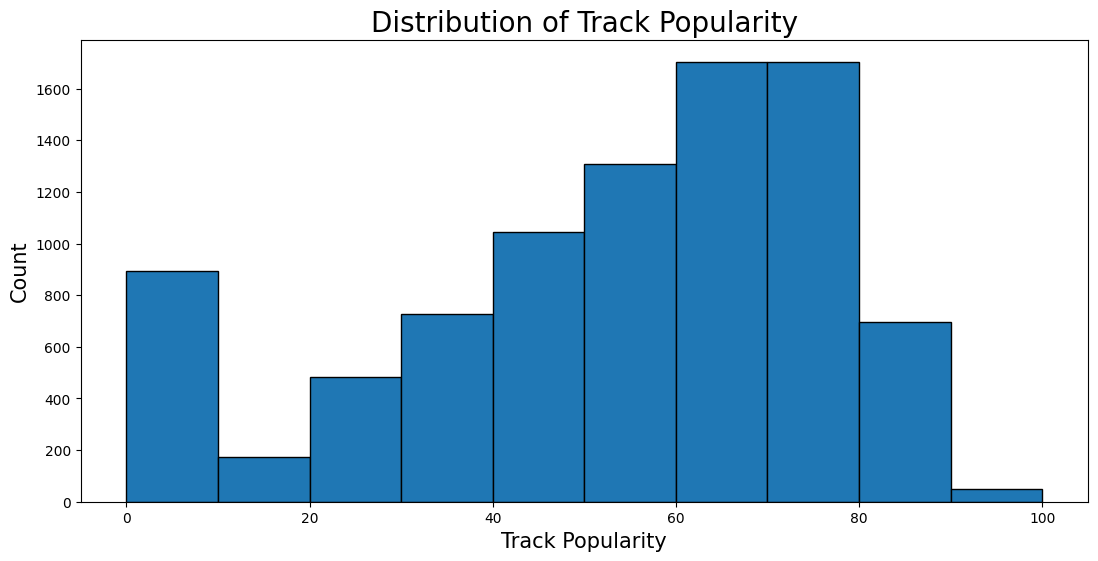

In [125]:
# Histogram of track popularity
plt.figure(figsize=(13, 6))
plt.hist(df.track_popularity, edgecolor='black')
plt.xlabel("Track Popularity", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Track Popularity", fontsize=20)
plt.show()

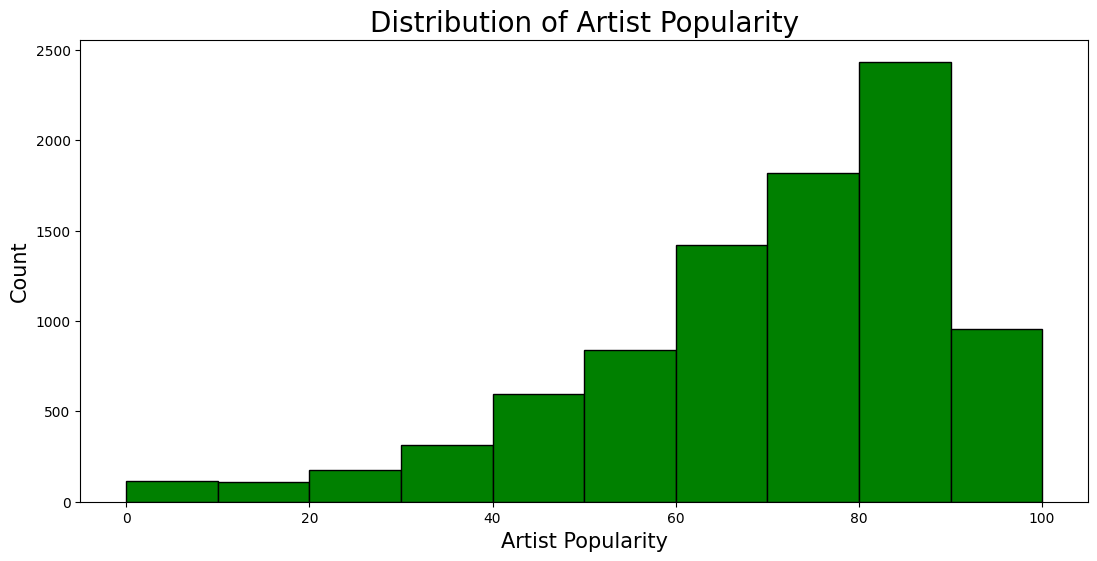

In [126]:
# Histogram of artist followers
plt.figure(figsize=(13, 6))
plt.hist(df.artist_popularity, edgecolor='black', color='green')
plt.xlabel("Artist Popularity", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Artist Popularity", fontsize=20)
plt.show()

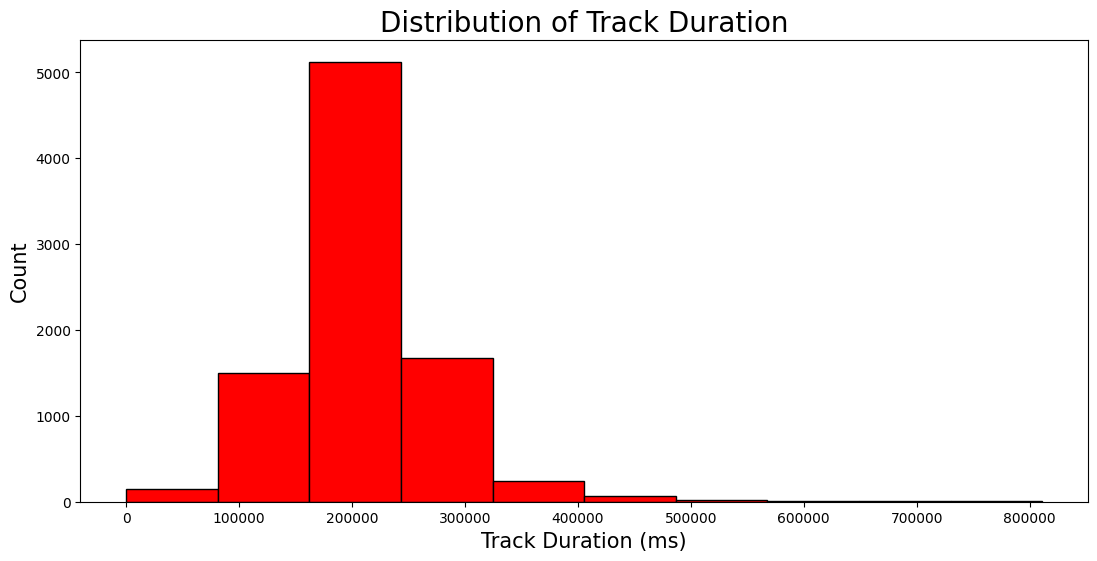

In [127]:
# Histogram of track duration
plt.figure(figsize=(13, 6))
plt.hist(df.track_duration_ms, edgecolor='black', color='red')
plt.xlabel("Track Duration (ms)", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Track Duration", fontsize=20)
plt.show()

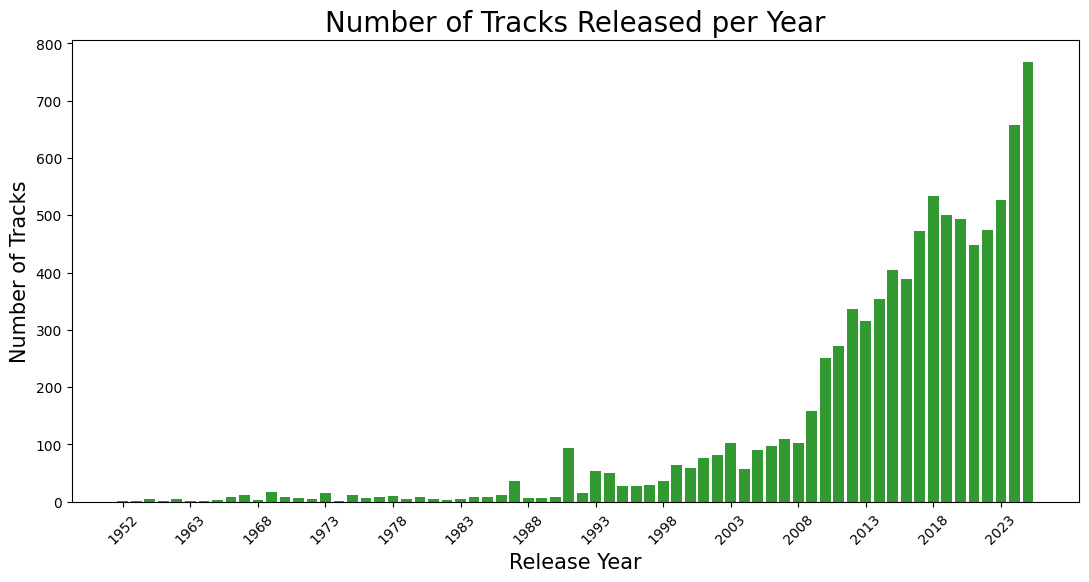

In [128]:
# Bar chart of number of tracks released per year
plt.figure(figsize=(13, 6))
tracks_per_year = df.year.astype(str).value_counts().sort_index()[1:] # Exclude year 0
plt.bar(tracks_per_year.index, tracks_per_year.values, color='green', alpha=0.8)
plt.xticks(tracks_per_year.index[::5], rotation=45)
plt.xlabel("Release Year", fontsize=15)
plt.ylabel("Number of Tracks", fontsize=15)
plt.title("Number of Tracks Released per Year", fontsize=20)
plt.show()

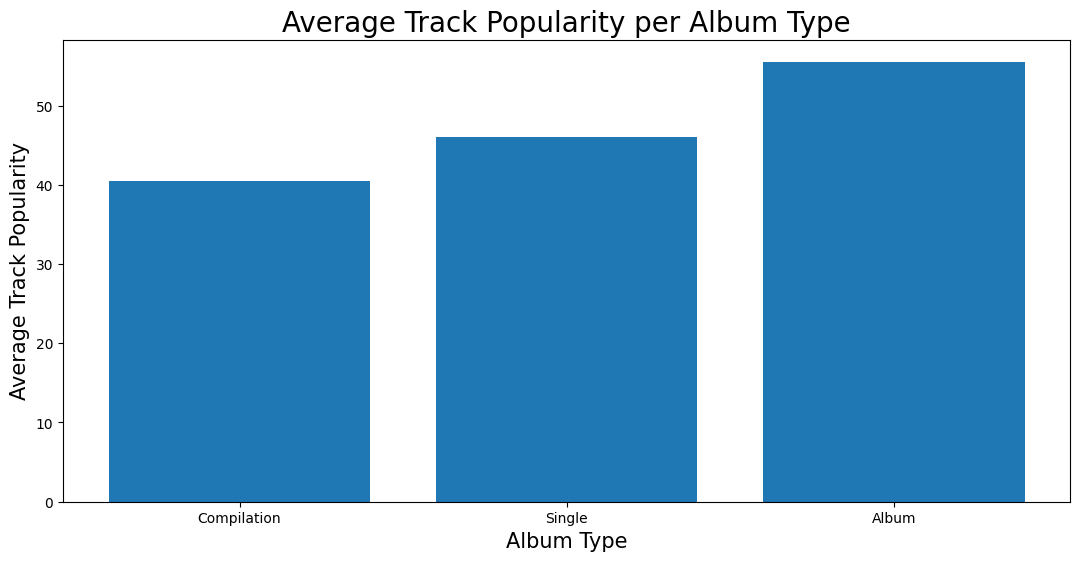

In [129]:
# Bar chart of average track popularity per album type
plt.figure(figsize=(13, 6))
avg_popularity_per_album_type = df.groupby("album_type").track_popularity.mean()
plt.bar(avg_popularity_per_album_type.index, avg_popularity_per_album_type.values)
plt.xticks(avg_popularity_per_album_type.index, ['Compilation', 'Single', 'Album'])
plt.xlabel("Album Type", fontsize=15)
plt.ylabel("Average Track Popularity", fontsize=15)
plt.title("Average Track Popularity per Album Type", fontsize=20)
plt.show()

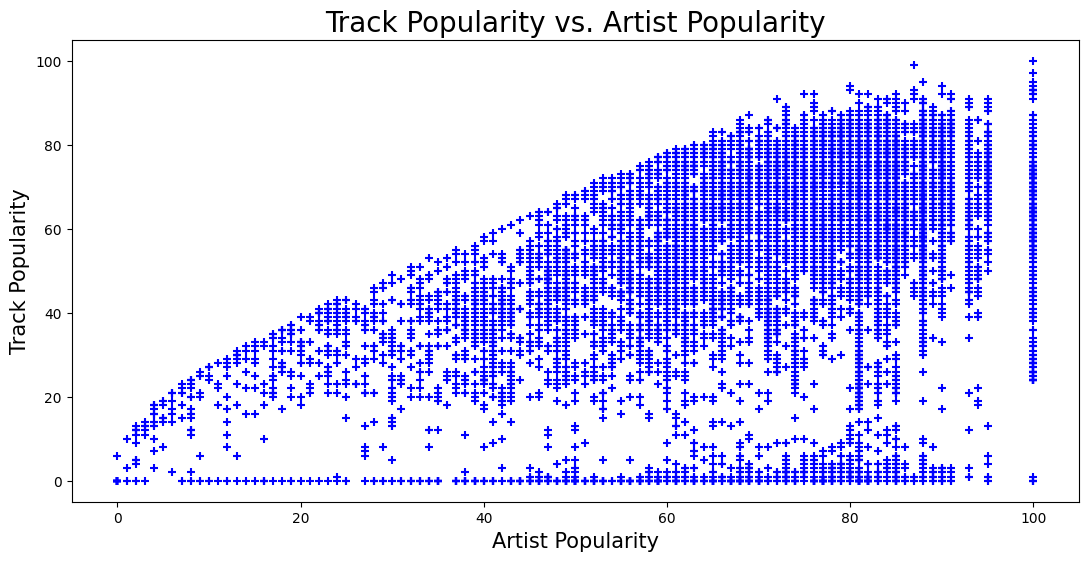

In [130]:
# Scatter plot of track popularity vs. artist popularity
plt.figure(figsize=(13, 6))
plt.scatter(df.artist_popularity, df.track_popularity, color='blue', marker='+')
plt.xlabel("Artist Popularity", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Artist Popularity", fontsize=20)
plt.show()

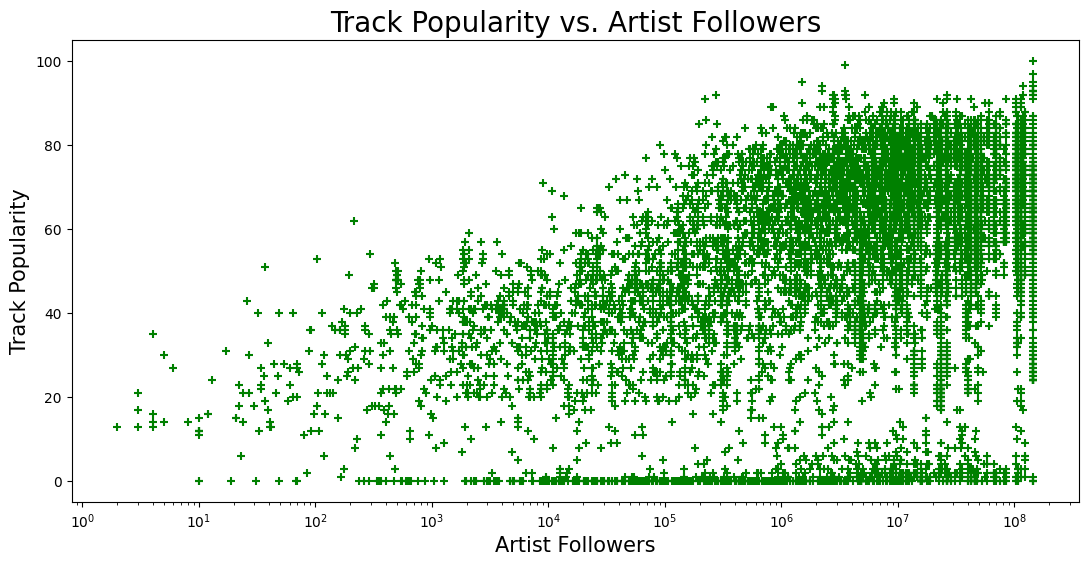

In [131]:
# Scatter plot of track popularity vs. artist followers
plt.figure(figsize=(13, 6))
plt.scatter(df.artist_followers, df.track_popularity, color='green', marker='+')
plt.xscale('log')
plt.xlabel("Artist Followers", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Artist Followers", fontsize=20)
plt.show()

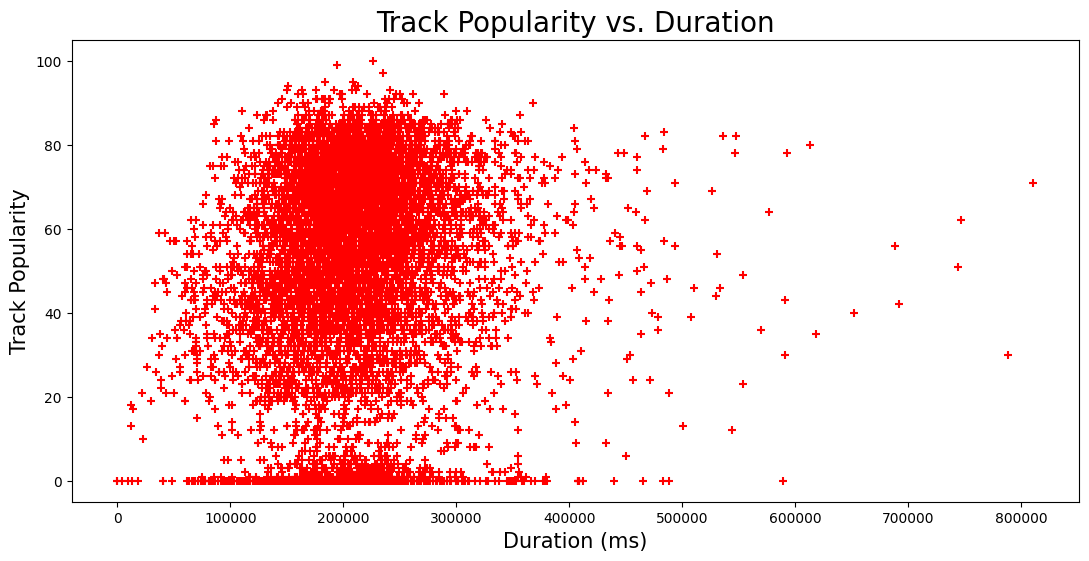

In [132]:
# Scatter plot of track popularity vs. duration
plt.figure(figsize=(13, 6))
plt.scatter(df.track_duration_ms, df.track_popularity, color='red', marker='+')
plt.xlabel("Duration (ms)", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Duration", fontsize=20)
plt.show()

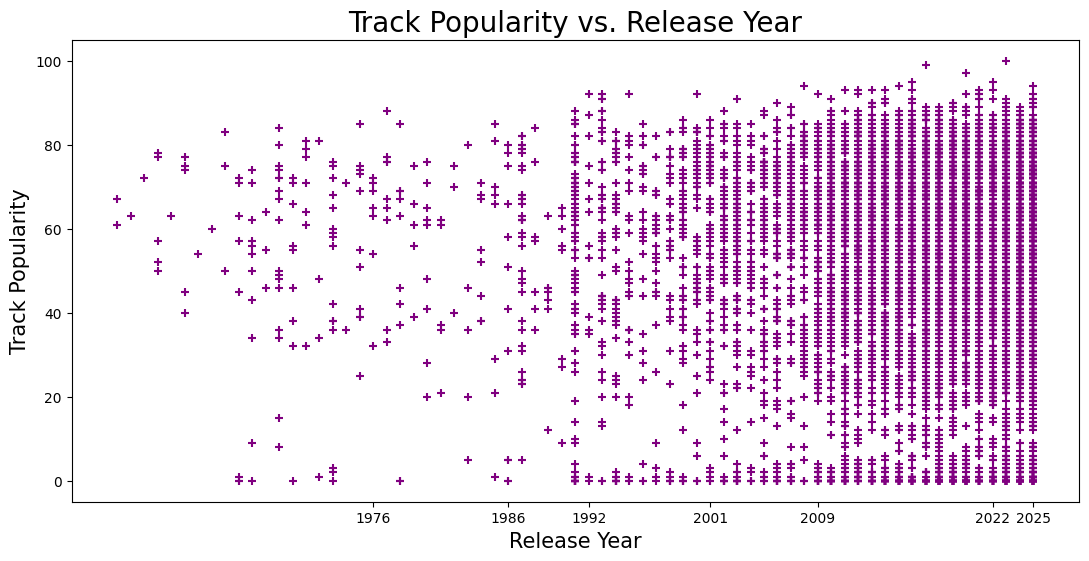

In [133]:
# Scatter plot of track popularity vs. release year
plt.figure(figsize=(13, 6))
plt.scatter(sorted(df.year.astype(str)), df.track_popularity, color='purple', marker='+')
plt.xticks(df.year.astype(str).unique()[::10])
plt.xlabel("Release Year", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Release Year", fontsize=20)
plt.show()

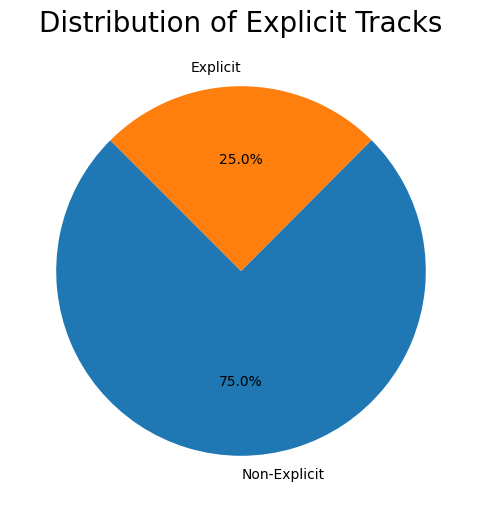

In [134]:
# Pie chart of explicit tracks
plt.figure(figsize=(13, 6))
data = df.explicit.value_counts().tolist()
labels = ['Non-Explicit', 'Explicit']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=135)
plt.title("Distribution of Explicit Tracks", fontsize=20)
plt.show()

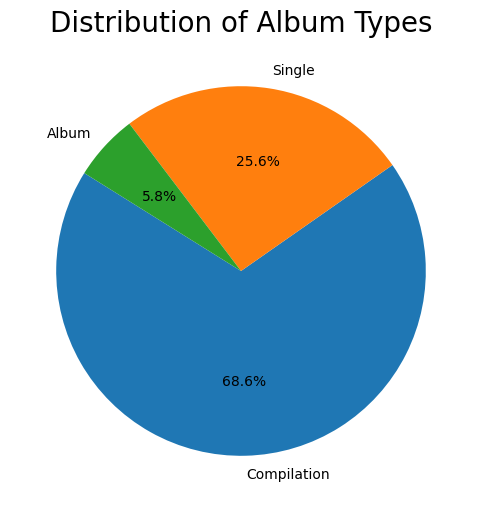

In [135]:
# Pie chart of album types
plt.figure(figsize=(13, 6))
data = df.album_type.value_counts().tolist()
labels = ['Compilation', 'Single', 'Album']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=148)
plt.title("Distribution of Album Types", fontsize=20)
plt.show()

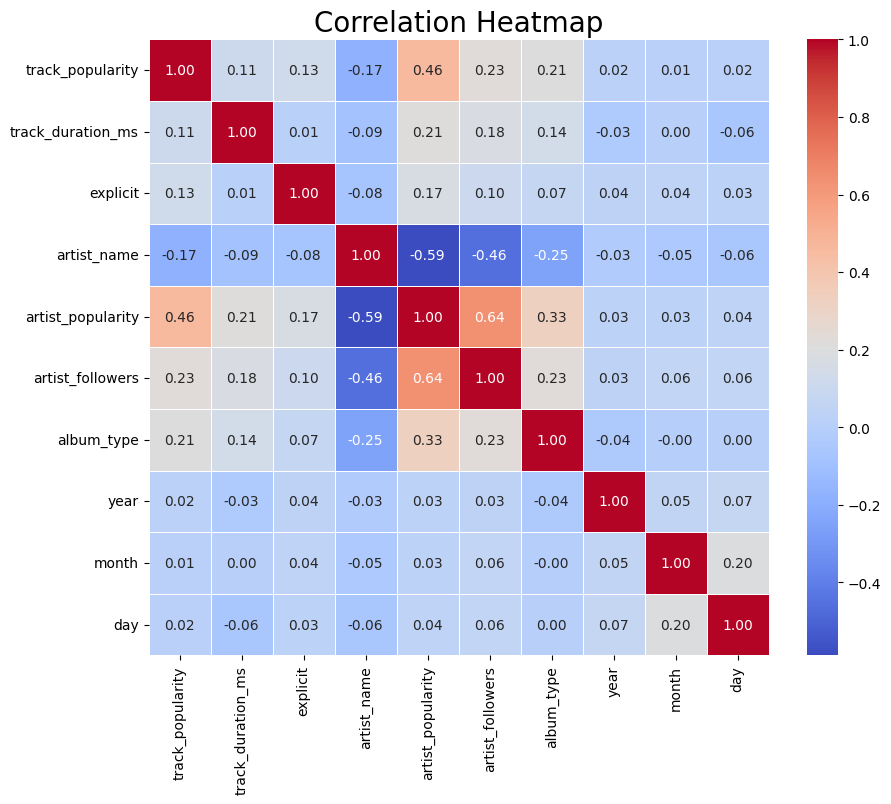

In [136]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=0.5,  cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

---

## 6. Outlier Removal
Some values may be too big for our machine learning model to interpret in any way. Hence, these extreme cases will create noise for it that will reduce its performance.

In [137]:
print("Longest track : " + str(max(df["track_duration_ms"])))
print("Median of the tracks' length : " + str(df["track_duration_ms"].median()))

# removing tracks of length greater than 3 minutes
df.drop(df[df["track_duration_ms"] >= 300000].index, inplace=True)

Longest track : 811077
Median of the tracks' length : 207276.0


In [138]:
print("Artist with the least amount of followers : " + str(min(df["artist_followers"])))
print("Median of artists' followers : " + str(df["artist_followers"].median()))

# removing tracks belonging to artists with too few followers
df.drop(df[df["artist_followers"] <= 10000].index, inplace=True)

Artist with the least amount of followers : 0.0
Median of artists' followers : 6132588.0


In [139]:
print("Year with the least amount of tracks released : " + str())
for year in np.sort(df["year"].unique()) : 
    print(str(year) + " number of tracks : " + str(df[df["year"] == year].__len__()))

Year with the least amount of tracks released : 
0 number of tracks : 2
1952 number of tracks : 1
1958 number of tracks : 1
1959 number of tracks : 5
1960 number of tracks : 1
1962 number of tracks : 5
1963 number of tracks : 1
1964 number of tracks : 1
1965 number of tracks : 3
1966 number of tracks : 8
1967 number of tracks : 10
1968 number of tracks : 1
1969 number of tracks : 16
1970 number of tracks : 6
1971 number of tracks : 5
1972 number of tracks : 3
1973 number of tracks : 10
1974 number of tracks : 1
1975 number of tracks : 4
1976 number of tracks : 5
1977 number of tracks : 9
1978 number of tracks : 7
1979 number of tracks : 5
1980 number of tracks : 9
1981 number of tracks : 5
1982 number of tracks : 3
1983 number of tracks : 4
1984 number of tracks : 7
1985 number of tracks : 6
1986 number of tracks : 9
1987 number of tracks : 28
1988 number of tracks : 5
1989 number of tracks : 6
1990 number of tracks : 5
1991 number of tracks : 79
1992 number of tracks : 13
1993 number 

In [140]:
# it pains me to say so, but let's delete songs from before the 90's
df.drop(df[df["year"].astype(int) <= 1990].index, inplace=True)

In [141]:
df.head()

,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,album_type,year,month,day
0,61,213173,0,0,80.0,17755451.0,0,2009,11,9
1,67,158760,0,1,69.0,293734.0,1,2023,1,13
2,63,225328,0,2,100.0,145396321.0,2,2021,4,9
3,72,158463,1,3,90.0,118692183.0,2,2021,7,30
4,57,267013,0,4,90.0,68997177.0,2,2010,1,1


## 7. Unsupervised learning : K Means model

This model will group songs together in order to create clusters of similar songs, making characteristics emrge.

### 7.1. Finding the best K amount of clusters

We now use the Elbow method to determine the number of clusters, but first we need to determine the error rate for each K number of clusters.

Text(0, 0.5, 'Error Rate')

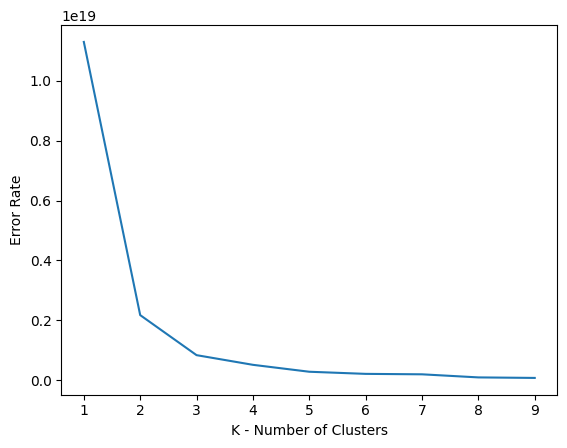

In [142]:
from sklearn.cluster import KMeans

error = []
k_range = range(1,10) # We arbitrarily pick 10 as max as it is less than likely that we will choose more than 10 clusters
for K in k_range :
    km = KMeans(n_clusters=K)
    km.fit(df[['track_popularity','track_duration_ms','explicit','artist_name','artist_popularity','artist_followers','album_type','year','month','day']])
    error.append(km.inertia_) # = error rate

plt.plot(k_range,error)
plt.xlabel('K - Number of Clusters')
plt.ylabel('Error Rate')

Using the elbow method we determine 3 to be the best number of clusters for our model

### 7.2. Applying the K Means model to our model

In [143]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df[['track_popularity','track_duration_ms','explicit','artist_name','artist_popularity','artist_followers','album_type','year','month','day']])
y_predicted

array([0, 0, 1, ..., 1, 0, 1])

In [144]:
# We add the cluster number to each data
df['cluster'] = y_predicted
df.head()

,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,album_type,year,month,day,cluster
0,61,213173,0,0,80.0,17755451.0,0,2009,11,9,0
1,67,158760,0,1,69.0,293734.0,1,2023,1,13,0
2,63,225328,0,2,100.0,145396321.0,2,2021,4,9,1
3,72,158463,1,3,90.0,118692183.0,2,2021,7,30,1
4,57,267013,0,4,90.0,68997177.0,2,2010,1,1,2


### 7.3. Visualize the clusters
And now to visualize it all, we will plot each cluster with respect to our different columns. For instance, it might be interesting to plot all the songs according to the artist's popularity with respect to its amount of followers.

Text(0, 0.5, 'artist_followers')

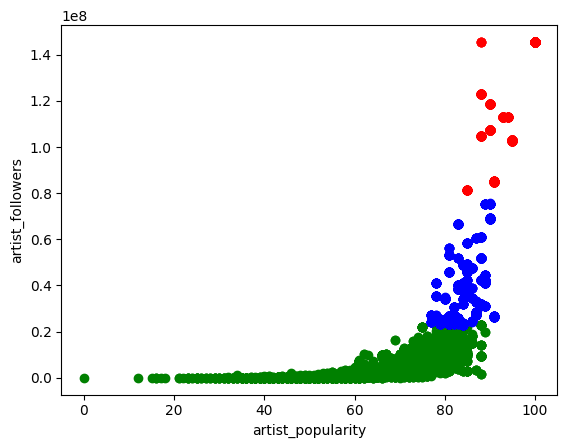

In [145]:
df1 = df[df['cluster'] == 0]
df2 = df[df['cluster'] == 1]
df3 = df[df['cluster'] == 2]

plt.scatter(df1['artist_popularity'],df1['artist_followers'],color='green')
plt.scatter(df2['artist_popularity'],df2['artist_followers'],color='red')
plt.scatter(df3['artist_popularity'],df3['artist_followers'],color='blue')
plt.xlabel('artist_popularity')
plt.ylabel('artist_followers')

# The graph below is a logical example because the more followers an artist has, generally speaking the more popular he is

Text(0, 0.5, 'album_type')

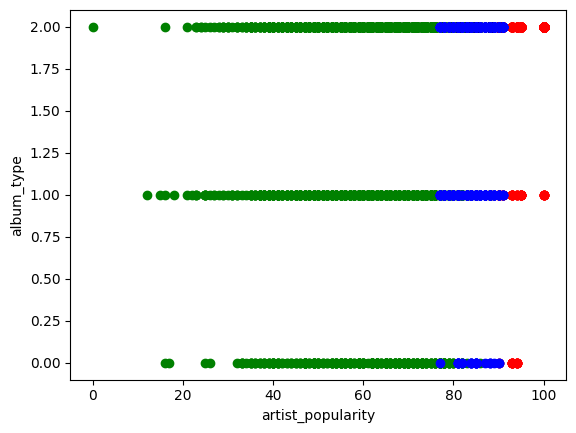

In [146]:
plt.scatter(df1['artist_popularity'],df1['album_type'],color='green')
plt.scatter(df2['artist_popularity'],df2['album_type'],color='red')
plt.scatter(df3['artist_popularity'],df3['album_type'],color='blue')
plt.xlabel('artist_popularity')
plt.ylabel('album_type')

Text(0, 0.5, 'year')

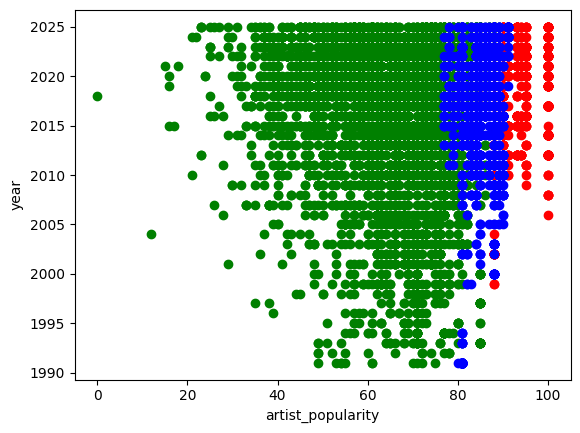

In [147]:
plt.scatter(df1['artist_popularity'],df1['year'],color='green')
# alpha adds the transparency on the dots so we can better determine when many points are stacked upon each others
plt.scatter(df2['artist_popularity'],df2['year'],color='red')
plt.scatter(df3['artist_popularity'],df3['year'],color='blue')
plt.xlabel('artist_popularity')
plt.ylabel('year')

#### Although a bit complicated to decipher, we can discern the 3 main groups clearly :
- In Green we have the "General/Average artists" cluster which regroups the most tracks and are not exceptionally popular
- In Blue we have the "Up and coming artists" cluster which contains some recent and popular tracks (mostly after 2012)
- In Red we finally have the "Top artists" cluster which represents the artists that are the most popular out of everyone, most of them are fairly recent (2010's) but we can still see one or two major artists from before 2000, these are "Classic" artists who are still really popular even after decades (for example Michael Jackson and other big names of this era)

## 8. Supervised Learning : K Nearest Neighbors model
We will try to predict the popularity of a track or an artist according to our data based on its nearest neighbors. Let's say a song is released by a popular artist and if other popular artists have their music on top of charts, the model will guess that this new song might be popular.

### 8.1. Set up

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# we standardize the values, in order to make it more accessible to our model
X = df.copy()
Xstand = StandardScaler().fit_transform(X)
Xstand = pd.DataFrame(Xstand, columns=X.columns)

# we take the 2 columns that we'll have to predict later on
y_pop = Xstand['track_popularity']
y_cluster = X['cluster']

### 8.2. Predict the popularity of a song

#### 8.2.1 Finding the best K

In order to predict the popularity of a given track, we use a regressor because it is a numerical value prediction.
<br>First we need to determine the best number of neighbors.

In [149]:
X = X.drop('track_popularity', axis=1)  # We remove the track popularity column since we want to predict it and not train on it

X_train, X_test, y_train, y_test = train_test_split(Xstand, y_pop, test_size=0.2, random_state=42)
errors = []
for k in range(1,21):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train,y_train)
    ypredAnswers = model.predict(X_test)
    error = mean_squared_error(y_test,ypredAnswers)
    errors.append(error)
    
print(errors)
print(min(errors))
neigh = errors.index(min(errors)) + 1 # Obtain the number of neighbor for which the error is minimal (array starts at 0 so +1)
print("The perfect number of neighbors is :",neigh)


[0.09866792472993657, 0.07675000276568511, 0.07455983038529765, 0.07227576401005525, 0.07012672590215258, 0.0684793495162381, 0.06756967432623341, 0.0685829795948081, 0.07071506455043858, 0.07243308637899679, 0.07362068131825691, 0.07543963698750229, 0.07638557362572648, 0.07878686856164703, 0.0809339828958915, 0.08306444151681468, 0.08418892706543642, 0.08651102836862243, 0.08827526908726459, 0.08963134029329321]
0.06756967432623341
The perfect number of neighbors is : 7


Text(0, 0.5, 'Inertia (Error)')

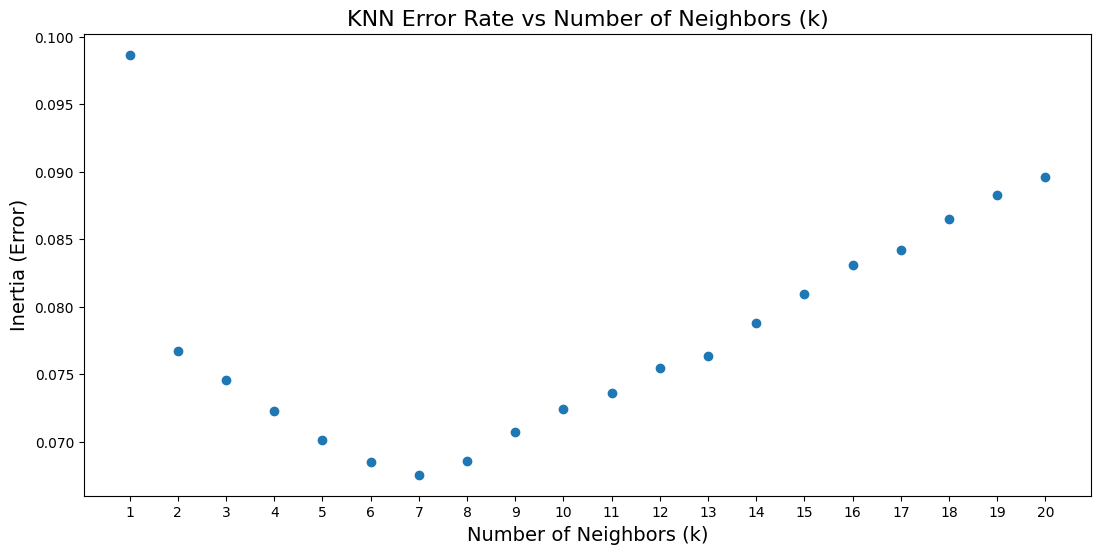

In [150]:
# We can better visualize it by plotting all neighbor numbers according to their cumulative error
plt.figure(figsize=(13, 6))  
plt.scatter(range(1, 21), errors, marker='o')
plt.xticks(range(1, 21))  

plt.title("KNN Error Rate vs Number of Neighbors (k)", fontsize=16)
plt.xlabel("Number of Neighbors (k)", fontsize=14)
plt.ylabel("Inertia (Error)", fontsize=14)

#### 8.2.2. Testing and verifying accuracy

Let's test it by trying to predict values picked up from our data and let's check its accuracy with different indicators.

In [151]:
knn_reg = KNeighborsRegressor(n_neighbors=neigh)
knn_reg.fit(X_train, y_train)
y_pred_pop = knn_reg.predict(X_test)

AvgError= mean_squared_error(y_test, y_pred_pop)
r2 = r2_score(y_test, y_pred_pop)

print("The total error is :", AvgError)
print("R² Score:", r2)

The total error is : 0.06756967432623341
R² Score: 0.9303955224787868


### 8.3. Predict the cluster a song belongs to

#### 8.3.1. Finding the best K

In [152]:
X = df.copy()
X = df.drop('cluster', axis=1)
Xstand = StandardScaler().fit_transform(X)
Xstand = pd.DataFrame(Xstand, columns=X.columns)

In [153]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(Xstand, y_cluster, test_size=0.2, random_state=42)

errors = []
for k in range(1,21):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_c,y_train_c)
    ypredAnswers = model.predict(X_test_c)
    error = mean_squared_error(y_test_c,ypredAnswers)
    errors.append(error)

print(errors)
print(min(errors))
neigh = errors.index(min(errors)) + 1 # Obtain the number of neighbor for which the error is minimal
print("The perfect number of neighbors is :",neigh)

[0.12331536388140162, 0.1334231805929919, 0.1280323450134771, 0.14622641509433962, 0.13005390835579514, 0.14892183288409702, 0.14285714285714285, 0.13409703504043127, 0.12533692722371967, 0.15498652291105122, 0.13274932614555257, 0.14285714285714285, 0.14150943396226415, 0.15902964959568733, 0.14824797843665768, 0.15902964959568733, 0.14353099730458221, 0.17587601078167117, 0.15700808625336926, 0.17587601078167117]
0.12331536388140162
The perfect number of neighbors is : 1


Text(0, 0.5, 'Mean Squared Error')

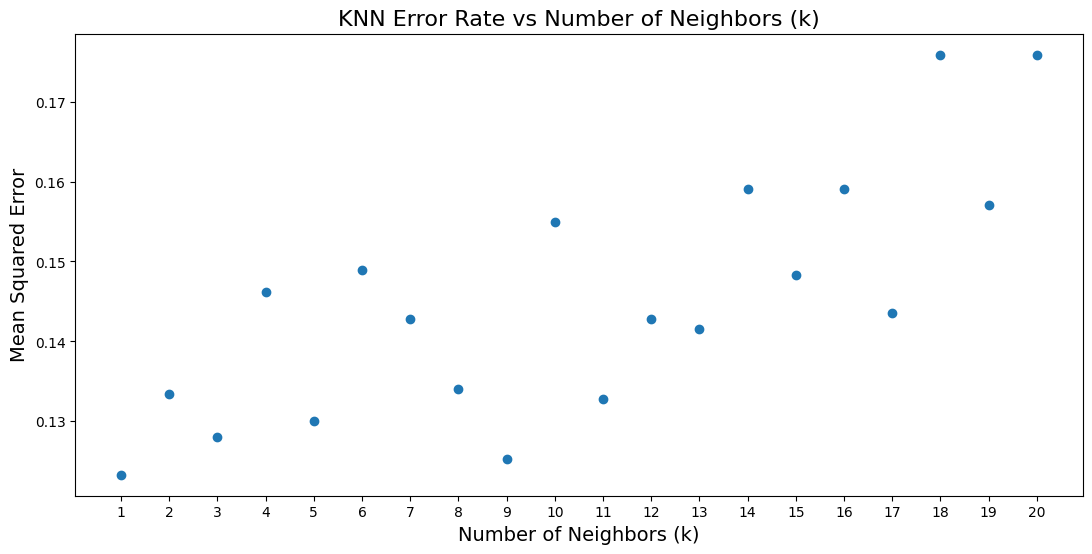

In [154]:

# We can better visualize it by plotting all neighbor numbers according to their cumulative error
plt.figure(figsize=(13, 6))  

plt.scatter(range(1, 21), errors, marker='o')
plt.xticks(range(1, 21))  # Proper ticks from 1 to 20

plt.title("KNN Error Rate vs Number of Neighbors (k)", fontsize=16)
plt.xlabel("Number of Neighbors (k)", fontsize=14)
plt.ylabel("Mean Squared Error", fontsize=14)


#### 8.3.2. Testing and verifying accuracy

In [155]:
knn_cluster = KNeighborsClassifier(n_neighbors=neigh)
knn_cluster.fit(X_train_c, y_train_c)


y_pred_cl = knn_cluster.predict(X_test_c)
Accuracy = accuracy_score(y_test_c, y_pred_cl)
print("Accuracy:", Accuracy)
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_cl))

cm = confusion_matrix(y_test_c, y_pred_cl)
print("Confusion Matrix : ")
print(cm)
# We found that Classification report is a useful method that synthetizes the data efficiently for each cluster

Accuracy: 0.967654986522911

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1024
           1       1.00      0.98      0.99       175
           2       0.90      0.93      0.92       285

    accuracy                           0.97      1484
   macro avg       0.96      0.96      0.96      1484
weighted avg       0.97      0.97      0.97      1484

Confusion Matrix : 
[[998   0  26]
 [  0 172   3]
 [ 19   0 266]]


---

## 9. Testing on random new tracks

In [156]:
tracks_wout_cluster = pd.DataFrame([
    {
        'track_popularity' : 67,
        'track_duration_ms' : 218990,
        'explicit' : 1,
        'artist_name' : 2,
        'artist_popularity' : 100.0,
        'artist_followers': 145396321.0,
        'album_type' : 2,
        'year' : 2010,
        'month' : 1,
        'day' : 28,
    },
        {
        'track_popularity' : 42,
        'track_duration_ms' : 100000,
        'explicit' : 0,
        'artist_name' : 3,
        'artist_popularity' : 15.0,
        'artist_followers': 118692183.0,
        'album_type' : 1,
        'year' : 1992,
        'month' : 12,
        'day' : 2,
    },
        {
        'track_popularity' : 28,
        'track_duration_ms' : 33333,
        'explicit' : 1,
        'artist_name' : 4,
        'artist_popularity' : 90.0,
        'artist_followers': 68997177.0,
        'album_type' : 2,
        'year' : 2010,
        'month' : 1,
        'day' : 28,
    }
    ])

tracks_wout_cluster

,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,album_type,year,month,day
0,67,218990,1,2,100.0,145396321.0,2,2010,1,28
1,42,100000,0,3,15.0,118692183.0,1,1992,12,2
2,28,33333,1,4,90.0,68997177.0,2,2010,1,28


In [157]:
# Standardize the hand-made tracks 
features = ['track_popularity', 'track_duration_ms', 'explicit', 'artist_name', 'artist_popularity', 'artist_followers', 'album_type', 'year', 'month', 'day']

scaler = StandardScaler().fit(X[features])  # X is your original DataFrame used for training
tracks_wout_cluster_std = scaler.transform(tracks_wout_cluster[features])

# Predict clusters
pred_clusters = knn_cluster.predict(tracks_wout_cluster_std)
print("Predicted clusters for hand-made tracks:", pred_clusters)

Predicted clusters for hand-made tracks: [1 0 1]


C:\Users\linus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


---

## Conclusion 
As far as we're concerned, the result we have here are quite unconclusive. Twitching the data makes it hardly vary its result, unless we force a strict change of scale on one of the data (going from 10 000 followers to 1 000 000). <br>
However, we've noticed that explicit content is less popular and makes the result fall quite quickly compared to other parameters. On the other hand, the release date impacted our prediction less than what we originally thought. Track duration also seems to play a big role in this model but the biggest influence remains in the artist's popularity (and not in their amount of followers !).<br>

Anyhow, we can safely say that music platforms play a big part in this industry, since they push forward artists on the rise and all-time popular ones. Finding a way-in can be tougher than staying on top of the charts such as Michael Jackson and Taylor Swift. <br>
In order to perform a better analysis, we should combine it to models that treat indepedently the genre of the music and link it to the social and cultural environment around social medias, which favored unknown artists of peculiar genres (like BoyWithUke, reaching hundreds of millions of streams in a couple of months thanks to TikTok).